# Error bars

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

$$
\newcommand{\dt}{\Delta t}
\newcommand{\udt}[1]{u^{({#1})}(T)}
\newcommand{\Edt}[1]{E^{({#1})}}
$$

We're starting from Euler's method, which is first order. That means that the difference between the exact solution $u(T)$ and the numerical approximation $\udt{\dt}$ should be proportional to $\dt$: that is, 

$$
\begin{equation}
  u(T) - \udt{\dt} = c_1 \dt + {\cal O}(\dt^2) \simeq c_1 \dt^{s_e}
\end{equation}
$$

with $s_e=1$. The problem is that the measured slope $s_m$ will be "contaminated" by the higher order terms, proportional to $\dt^2$ and higher powers of $\dt$. For sufficiently small $\dt$ the measured value $s_m$ will be indistinguishable from the expected value $s_e=1$. However, we rarely get to use a sufficiently small $\dt$. So how close does $s_m$ need to be to $s_e$ to be close enough?

One argument that can be justified: $0.585 \lesssim s_m \lesssim 1.585$ is close enough when $s_e = 1$.

## Error bars and Richardson extrapolation

The argument starts by noting that what we care about is not the algorithm, but the solution $u(T)$. From the solution of *any* numerical algorithm we cannot compute $u(T)$ exactly, but only estimate it with some error. Given a set of numerical calculations - $\udt{\dt}, \udt{2\dt}$ for example - and a model of how the algorithm behaves, then both the exact solution *and* the error bars can be estimated. 

**Claim**: if two models estimate exact solutions that lie within each other's error bars, they are indistinguishable. Hence, if the model corresponding to the *measured* slope is consistent with that of the *expected* slope, the algorithm implemented is close enough.

To make this concrete, we need a model of the algorithm. The simplest models are

$$
\begin{align}
  u(T) - \udt{\dt} & = c_e \dt^{s_e}, \\
  u(T) - \udt{\dt} & = c_m \dt^{s_m}.
\end{align}
$$

Using [Richardson extrapolation](http://en.wikipedia.org/wiki/Richardson_extrapolation) we can estimate both the solution $u(T)$ and also the error $\Edt{\dt} = u(T) - \udt{\dt}$. For Richardson extrapolation we perform two numerical calculations $\udt{\dt}$ and $\udt{2\dt}$ and combine them as

$$
\begin{align}
  \udt{e} & = \frac{2^{s_e} \udt{\dt} - \udt{2\dt}}{2^{s_e} - 1}, & \Edt{e, \dt} & = \frac{\udt{\dt} - \udt{2\dt}}{2^{s_e} - 1}, \\
  \udt{m} & = \frac{2^{s_m} \udt{\dt} - \udt{2\dt}}{2^{s_m} - 1}, & \Edt{m, \dt} & = \frac{\udt{\dt} - \udt{2\dt}}{2^{s_m} - 1}.
\end{align}
$$

The models are consistent if

$$
\begin{equation}
  \udt{e} \in \udt{m} \pm \Edt{m, \dt} \quad \text{and} \quad \udt{m} \in \udt{e} \pm \Edt{e, \dt}.
\end{equation}
$$

That is, if both models predict the same exact solution, within their own error bounds, then we can't tell the difference between them, and they're close enough.

## Checking the MOOC solution

We can use this criteria to check the result from [the full phugoid model notebook](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb).

Let's take the code from there directly.

In [2]:
from math import sin, cos, log, ceil
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 30.0   # trim velocity in m s^{-1}   
C_D = 1/40.  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = v_t     # start at the trim velocity (or add a delta)
theta0 = 0.0 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 1000.0  # initial altitude

In [4]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [5]:
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

Now we're going to compute the result at a specific time and do the convergence test. We'll use an end time of `T=100` as in the original notebook, and convergence test on `v` as an example.

In [6]:
T = 100.0
dt_values = numpy.array([0.001*2**i for i in range(3)])
v_values = numpy.zeros_like(dt_values)
for i, dt in enumerate(dt_values):
    N = int(T/dt)+1
    t = numpy.linspace(0.0, T, N)
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N-1):
        u[n+1] = euler_step(u[n], f, dt)
    v_values[i] = u[-1,0]

We now have three calculated values of `v` using parameter values `dt=0.001, 0.002, 0.004`. As in the original notebook, we can measure the order of convergence using

$$
\begin{equation}
  s_m = \log_2 \left| \frac{\udt{4\dt} - \udt{2\dt}}{\udt{2\dt} - \udt{\dt}} \right|.
\end{equation}
$$

In [7]:
s_m = log(abs((v_values[2]-v_values[1])/(v_values[1]-v_values[0]))) / log(2.0)
print("Measured convergence rate is {:.4g}.".format(s_m))

Measured convergence rate is 1.023.


As in the original notebook, this is close to one, but not exactly one. So we now use the two most accurate data points with our two models, with *expected* convergence rate $s_e = 1$ and *measured* convergence rate $s_m \simeq 1.023$. We compute our exact solutions and error intervals.

In [8]:
v_exact_e = (2.0*v_values[0] - v_values[1])
v_exact_m = (2.0**s_m*v_values[0] - v_values[1]) / (2.0**s_m - 1.0)
error_e = abs(v_exact_e - v_values[0])
error_m = abs(v_exact_m - v_values[0])

Then we check if they are consistent:

In [9]:
print("Does the expected solution {:.7g} lie within the interval "
      "[{:.7g}, {:.7g}]\nfrom the measured model? {}".format(
        v_exact_e, v_exact_m-error_m, v_exact_m+error_m, 
        v_exact_m-error_m <= v_exact_e <= v_exact_m+error_m))
print("Does the measured solution {:.7g} lie within the interval "
      "[{:.7g}, {:.7g}]\nfrom the exact model? {}".format(
        v_exact_m, v_exact_e-error_e, v_exact_e+error_e, 
        v_exact_e-error_e <= v_exact_m <= v_exact_e+error_e))

Does the expected solution 29.8693 lie within the interval [29.86798, 29.87053]
from the measured model? True
Does the measured solution 29.86925 lie within the interval [29.86798, 29.87061]
from the exact model? True


So the two models are indistinguishable: $s_m \simeq 1.023$ is *close enough*.

## Finding the limits

So, how different can $s_m$ be from one and still be close enough? First, let's do this experimentally, by plotting the intervals as we vary $s_m$:

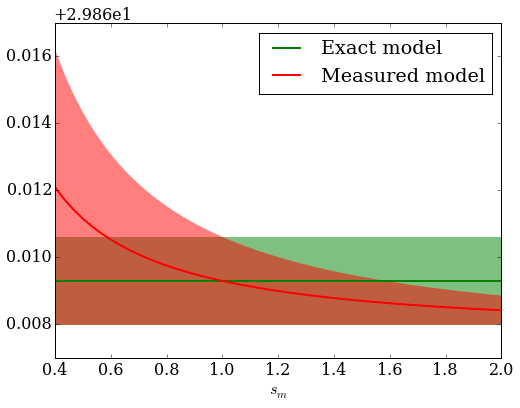

In [10]:
s_m_values = numpy.linspace(0.4, 2.0)
v_exact_m = numpy.zeros_like(s_m_values)
interval_lower = numpy.zeros_like(s_m_values)
interval_upper = numpy.zeros_like(s_m_values)
for i, s_m in enumerate(s_m_values):
    v_exact_m[i] = (2.0**s_m*v_values[0] - v_values[1]) / (2.0**s_m - 1.0)
    error_m = abs(v_exact_m[i] - v_values[0])
    interval_lower[i] = v_exact_m[i]-error_m
    interval_upper[i] = v_exact_m[i]+error_m
pyplot.figure(figsize=(8,6))
pyplot.plot(s_m_values, v_exact_e*numpy.ones_like(s_m_values), 'g-', linewidth=2, 
            label='Exact model')
pyplot.plot(s_m_values, v_exact_m, 'r-', linewidth=2, label='Measured model')
pyplot.fill_between(s_m_values, v_exact_e-error_e, v_exact_e+error_e, facecolor='green', 
                    alpha=0.5, edgecolor='None', label='Exact model interval')
pyplot.fill_between(s_m_values, interval_lower, interval_upper, facecolor='red', 
                    alpha=0.5, edgecolor='None', label='Measured model interval')
pyplot.legend()
pyplot.xlabel(r"$s_m$");

We see a few things. Firstly the lower limit is identical for both models for all $s_m$. This shouldn't be surprising: one of the edges of the interval will always be $\udt{\dt}$, from the definitions of the error and the interval.

Second, we see that for small enough $s_m$ the predicted solution for the measure model falls outside the interval for the exact model: this occurs when $s_m \simeq 0.6$. For large enough $s_m$, the predicted solution for the exact model falls outside the interval for the measured model: this occurs when $s_m \simeq 1.6$. 

This gives a very wide range of values for $s_m$ that are "close enough". Also, it's specific to this data. However, we can do a general calculation.

## The general interval

We have a definition for our two models, defining two intervals and the solutions that should fall within them. We can do a symbolic calculation to check when this happens. First, we write out the inequalities that need to be satisfied:

$$
\begin{equation}
\left| \frac{2^{s_e} y^{(h)} - y^{(2h)}}{2^{s_e} - 1} - \frac{2^{s_m} y^{(h)} - y^{(2h)}}{2^{s_m} - 1} \right| \le \left| \frac{y^{(2h)} - y^{(h)}}{2^{s_e} - 1} \right|
\end{equation}
$$

and

$$
\begin{equation}
\left| \frac{2^{s_e} y^{(h)} - y^{(2h)}}{2^{s_e} - 1} - \frac{2^{s_m} y^{(h)} - y^{(2h)}}{2^{s_m} - 1} \right| \le \left| \frac{y^{(2h)} - y^{(h)}}{2^{s_m} - 1} \right| .
\end{equation}
$$

Noting as above that only two need solving (as one edge of the inequality will always agree), we can solve:

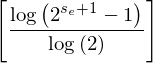

In [11]:
import sympy
sympy.init_printing()
yh, y2h, se, sm = sympy.symbols('y^h, y^{2h}, s_e, s_m')
Eq1 = sympy.Eq((2**sm*yh-y2h)/(2**sm-1)-(2**se*yh-y2h)/(2**se-1) , (y2h-yh)/(2**sm-1))
sympy.solve(Eq1, sm)

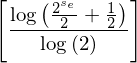

In [12]:
Eq2 = sympy.Eq((2**sm*yh-y2h)/(2**sm-1)-(2**se*yh-y2h)/(2**se-1) , -(y2h-yh)/(2**se-1))
sympy.solve(Eq2, sm)

So, for Euler's method where $s_e=1$ we find the interval must be:

In [13]:
print("Acceptable interval is [{:.6g}, {:.6g}].".format(log(1.0+0.5)/log(2.0), 
                                                        log(2.0**2-1.0)/log(2.0)))

Acceptable interval is [0.584963, 1.58496].


This matches well with the results above, and is completely independent of the data, and indeed the method: the only thing that matters is the expected convergence rate $s_e=1$. As we vary the expected convergence rate, the acceptable *measured* convergence rate also varies, and in fact the acceptable interval around $s_e$ gets larger:

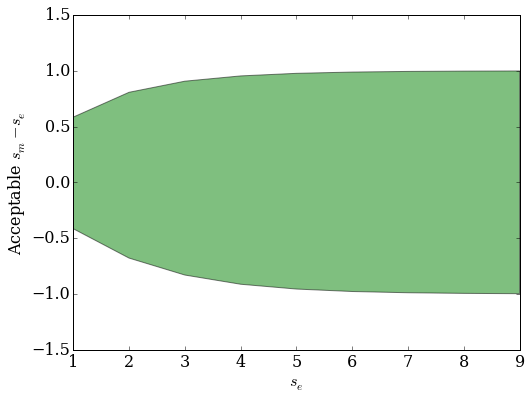

In [14]:
s_e = numpy.arange(1,10)
upper_limit = numpy.log(2.0**(s_e+1)-1.0)/numpy.log(2.0)
lower_limit = numpy.log(2.0**(s_e-1)+0.5)/numpy.log(2.0)
pyplot.figure(figsize=(8,6))
pyplot.fill_between(s_e, lower_limit-s_e, upper_limit-s_e, facecolor='green', alpha=0.5)
pyplot.xlabel(r'$s_e$')
pyplot.ylabel(r"Acceptable $s_m-s_e$")
pyplot.ylim(-1.5, 1.5);

## Summary

If all you care about is the answer that the algorithm gives you, then the measured convergence rate doesn't matter very much. Use Richardson extrapolation to estimate the exact solution, given multiple numerical solutions, and check that the estimated error is in a range that you're comfortable with.

#### More reading

See also [this page from NASA on grid convergence](http://www.grc.nasa.gov/WWW/wind/valid/tutorial/spatconv.html). Also [this paper by Liu](http://ocw.mit.edu/courses/mathematics/18-304-undergraduate-seminar-in-discrete-mathematics-spring-2006/projects/xtrpltn_liu_xpnd.pdf), which is rather mathematical, on Richardson extrapolation and its extensions.